<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Read-Enm-pickle-object" data-toc-modified-id="Read-Enm-pickle-object-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read Enm pickle object</a></span></li><li><span><a href="#Calculate-node-positions-with-spring-layout" data-toc-modified-id="Calculate-node-positions-with-spring-layout-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate node positions with spring layout</a></span></li><li><span><a href="#Network-plot" data-toc-modified-id="Network-plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Network plot</a></span><ul class="toc-item"><li><span><a href="#Figure-1B,-left" data-toc-modified-id="Figure-1B,-left-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Figure 1B, left</a></span></li><li><span><a href="#Figure-1B,-right" data-toc-modified-id="Figure-1B,-right-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Figure 1B, right</a></span></li></ul></li><li><span><a href="#Figure-1C" data-toc-modified-id="Figure-1C-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 1C</a></span></li><li><span><a href="#Figure-1D" data-toc-modified-id="Figure-1D-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Figure 1D</a></span></li><li><span><a href="#Figure-3C" data-toc-modified-id="Figure-3C-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Figure 3C</a></span></li><li><span><a href="#Figure-4B" data-toc-modified-id="Figure-4B-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Figure 4B</a></span></li><li><span><a href="#Figure-5D/F" data-toc-modified-id="Figure-5D/F-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Figure 5D/F</a></span></li></ul></div>

# Import packages

In [24]:
%load_ext autoreload
%autoreload 2
from matplotlib.lines import Line2D
import qgrid
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import os
import re
import itertools as itr
from enm.visualize import plot_correlation_density, plot_vector, plot_lambda_collectivity
from enm.Enm import Enm
from enm.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
#os.chdir('../')

# Read Enm pickle object

In [34]:
with open(snakemake.input.pickle_file_name,'rb') as f:
    e_pcc = pickle.load(f)



# Calculate node positions with spring layout

**This could be different from the ones shown in paper due to random node position calculation**

This does not change any claims in the paper

In [14]:
e_pcc.spring_pos(seed=12)

In [15]:
pos =e_pcc.graph_gc.nodes('pos')# nx.spring_layout(e_pcc.graph_gc,k=0.6,iterations=200, seed=11)#

# Network plot
## Figure 1B, left

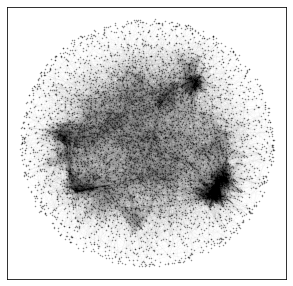

In [16]:
fig, ax =plt.subplots()

nx.draw_networkx_nodes(e_pcc.graph_gc,
                           node_size=0.2,
                           alpha=0.5,
                           node_color='k',
                           pos=pos,
                         ax=ax
                           # node_shape=matplotlib.markers.MarkerStyle(marker='o',fillstyle='full')
                           )
nx.draw_networkx_edges(e_pcc.graph_gc,
                           alpha= 0.1,
                           width= 0.1,
                           edge_color='k',
                           pos=pos,
                           label='PCC>0.2',ax=ax)


## Figure 1B, right

/home/oma21/enm_package/enm/visualize.py:334: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_heatmap.set_xticklabels(idx1_cl, minor=False)
/home/oma21/enm_package/enm/visualize.py:342: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_heatmap.set_yticklabels(idx2_cl, minor=False)


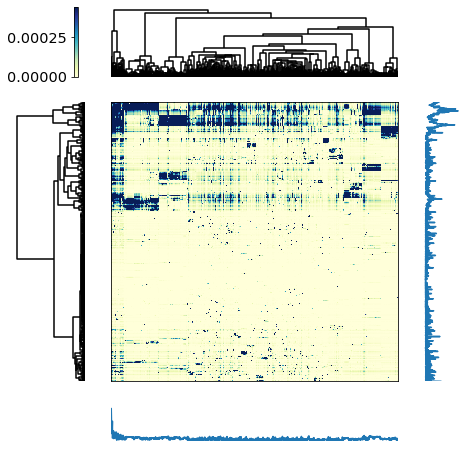

(array([0.00225456, 0.00212964, 0.00064455, ..., 0.0018722 , 0.00188671,
        0.00196717]),
 array([0.00670243, 0.00670243, 0.00610539, ..., 0.00030683, 0.00022774,
        0.00013241]))

In [15]:
e_pcc.heatmap_annotated()

# Figure 1C

`get_clustered_nodes` finds the gene names belonging the outmost, smaller cluster for rows and columns as shown.

In [16]:
cc = e_pcc.df.iloc[e_pcc.get_clustered_nodes('column'),:]
rc = e_pcc.df.iloc[e_pcc.get_clustered_nodes('row'),:]

#rc: row cluster
#cc: column cluster

In [18]:
df = e_pcc.df
df['cc'] = ['cc' if i in cc.orf_name.tolist() else 'other' for i in df.orf_name.tolist()]
df['rc'] = ['rc' if i in rc.orf_name.tolist() else 'other' for i in df.orf_name.tolist()]

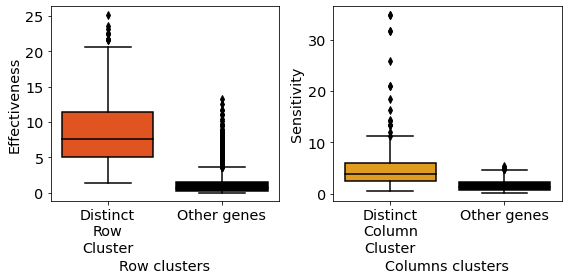

In [19]:
import seaborn as sns
color = {'cc': 'orange','other':'k','rc':'orangered'}
fig, ax = plt.subplots(1,2,figsize=(8,4))

sns.boxplot(data=df, x='rc',y='eff',order=['rc','other'],palette=color,ax=ax[0])
ax[0].set_xticklabels(['Distinct\nRow\nCluster', 'Other genes'])
ax[0].set_xlabel('Row clusters')
ax[0].set_ylabel('Effectiveness')

sns.boxplot(data=df, x='cc',y='sens',order=['cc','other'],palette=color,ax=ax[1])
ax[1].set_xticklabels(['Distinct\nColumn\nCluster', 'Other genes'])
ax[1].set_xlabel('Columns clusters')
ax[1].set_ylabel('Sensitivity')

plt.tight_layout()

#plt.savefig('reports/figures/network_images_040221/colcluster_sens.png')

# Figure 1D

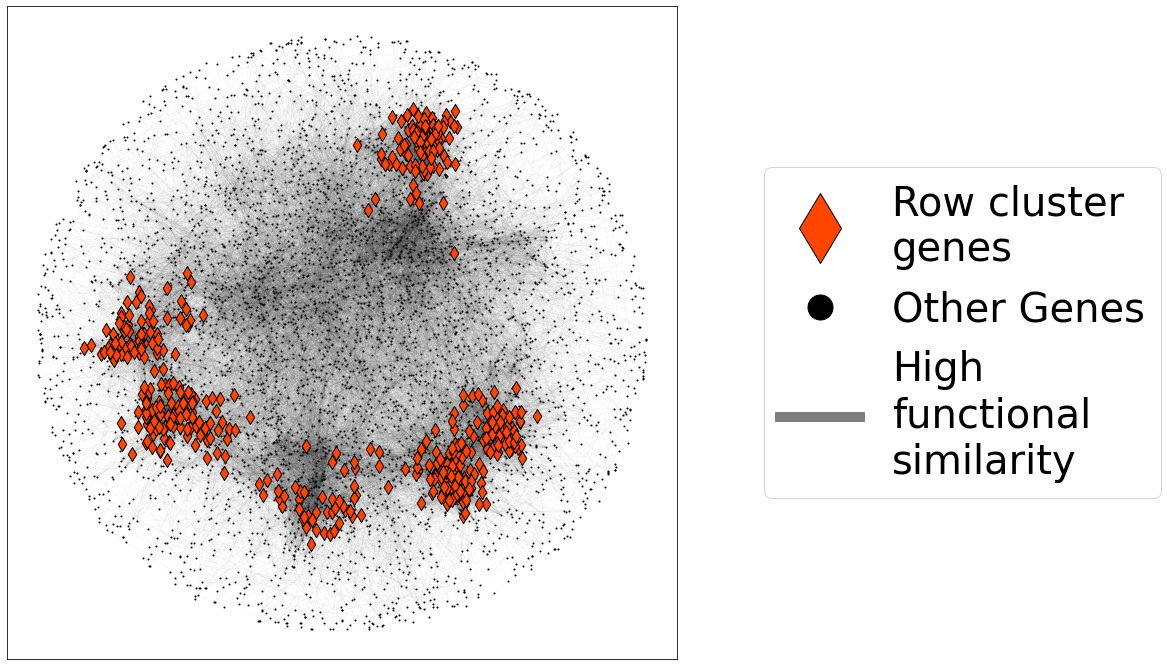

In [20]:
fig, ax = plt.subplots(figsize=(12,12))
#axs = ax.ravel()
legend_elements = [    ]

#for i in range(len(sensor_order)):
nx.draw_networkx_nodes(e_pcc.graph_gc, ax =ax , pos=pos,node_size=1, node_color='black')
nx.draw_networkx_edges(e_pcc.graph_gc, ax =ax , pos=pos,node_size=1, edge_color='black',alpha=0.2, width=0.1)
nx.draw_networkx_nodes(e_pcc.graph_gc, 
                       nodelist=rc.orf_name.tolist(),
                       ax=ax, 
                       pos=pos,
                       node_color='orangered',
                      edgecolors='black',
                      node_size=100,
                      node_shape='d')

ax.set_facecolor('white')
legend_elements.extend(
    [Line2D([0], [0], marker='d', color='black', label='Row cluster\ngenes',
                              markerfacecolor='orangered', markersize=50, linestyle="None"),
     Line2D([0], [0], marker='o', color='black', label='Other Genes',
                              markerfacecolor='black', markersize=25, linestyle="None"),
#                    Line2D([0], [0], marker='o', color='black', label='Effectors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='^', color='black', label='Sensors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'High\nfunctional\nsimilarity',
                              markerfacecolor='black', markersize=0, linestyle="-", alpha=0.5,lw=10)
    ]
)
lgd = ax.legend(handles=legend_elements, fontsize=40,loc='center left', bbox_to_anchor=(1.1, 0.5))


#nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
#plt.savefig('reports/figures/network_images_040221/rowcluster_nw_map.png',bbox_inches='tight')

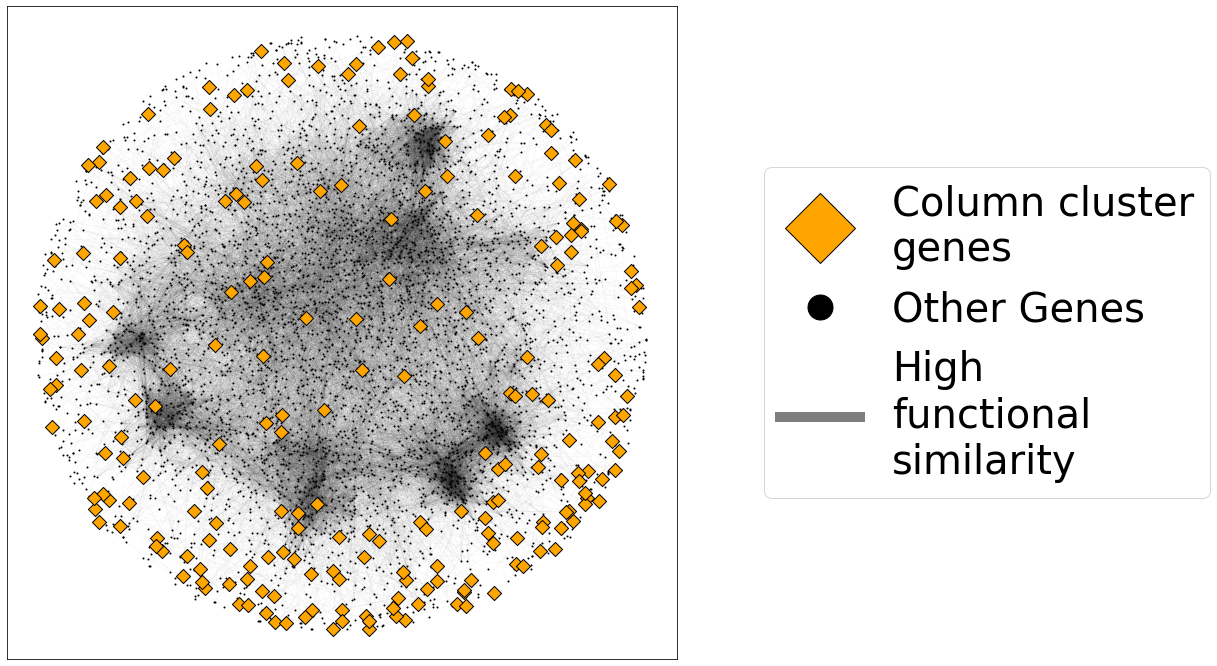

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
#axs = ax.ravel()
legend_elements = [    ]

#for i in range(len(sensor_order)):
nx.draw_networkx_nodes(e_pcc.graph_gc, ax =ax , pos=pos,node_size=1, node_color='black')
nx.draw_networkx_edges(e_pcc.graph_gc, ax =ax , pos=pos,node_size=1, edge_color='black',alpha=0.2, width=0.1)
nx.draw_networkx_nodes(e_pcc.graph_gc, 
                       nodelist=cc.orf_name.tolist(),
                       ax=ax, 
                       pos=pos,
                       node_color='orange',
                      edgecolors='black',
                      node_size=100,
                      node_shape='D')

ax.set_facecolor('white')
legend_elements.extend([
    Line2D([0], [0], marker='D', color='black', label='Column cluster\ngenes',
                              markerfacecolor='orange', markersize=50, linestyle="None"),
    Line2D([0], [0], marker='o', color='black', label='Other Genes',
                              markerfacecolor='black', markersize=25, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'High\nfunctional\nsimilarity',
                              markerfacecolor='black', markersize=0, linestyle="-", alpha=0.5,lw=10),
    ]
)
lgd = ax.legend(handles=legend_elements, fontsize=40,loc='center left', bbox_to_anchor=(1.1, 0.5))


#nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
#plt.savefig('reports/figures/network_images_040221/colcluster_nw_map.png',bbox_inches='tight')

# Figure 3C

In [17]:
sensors_pcc = pd.read_csv(snakemake.input.sensors_pcc)
sensor_colors = ["#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#FFFF33"]
sensor_order = sensors_pcc.groupby('go_group').sens.median().sort_values().index.tolist()

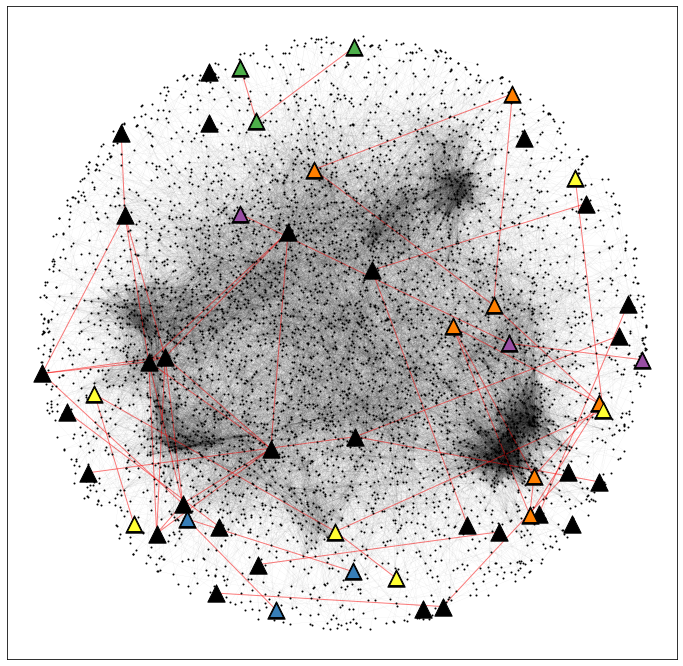

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
#axs = ax.ravel()
legend_elements = [    ]

#for i in range(len(sensor_order)):
e_pcc.plot_network_spring(ax=ax,
                          node_size=1,
                          node_color='black',
 #                        node_size = [100 if i in sensors_pcc.orf_name.values or i in effector_pcc.orf_name.values else 1 for i in e_pcc.nodes],
                         #node_color = ['red' if i in sensors_pcc.orf_name.values else 'blue' if i in effector_pcc.orf_name.values else 'black' for i in e_pcc.nodes],
                         edge_color='black',savefig=False)
    #                         node_shape=['^' if i in sensors_pcc.orf_name.values else 'v' if i in effector_pcc.orf_name.values else 'o' for i in e_pcc.nodes])
    # nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=sensors_pcc.orf_name.values, node_size=200, pos=pos,
    #                           node_color='black',
    #                           node_shape='^',edgecolors='black',
    #                           linewidths=1)
nx.draw_networkx_nodes(nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.orf_name.tolist()),
                       pos=pos, 
                       node_color='black', alpha=1, node_shape='^')

for itr, i in enumerate(sensor_order):
    #print(i, effector_colors[itr])

    orf_names_to_plot = sensors_pcc.loc[sensors_pcc.go_group==i, 'orf_name'].tolist()
    nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
                          node_color=sensor_colors[itr],
                          node_shape='^',edgecolors='black',
                          linewidths=1)
    legend_elements.append(
        Line2D([0], [0], marker='^', color='black', label=f'Sensors ({i})',
                              markerfacecolor=sensor_colors[itr], markersize=30, linestyle="None")
    )
ax.set_facecolor('white')
legend_elements.append(
        Line2D([0], [0], marker='^', color='black', label=f'Sensors (No GO Enrichments )',
                              markerfacecolor='black', markersize=30, linestyle="None")
    )
legend_elements.extend(
    [Line2D([0], [0], marker='o', color='black', label='Other Genes',
                              markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='o', color='black', label='Effectors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='^', color='black', label='Sensors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'High functional similarity',
                              markerfacecolor='black', markersize=0, linestyle="-", alpha=0.5, lw=10),
                   Line2D([0], [0], marker='o', color='red', label= 'Sensor-Sensor edges',
                              markerfacecolor='#018571', markersize=0, linestyle="-",lw=10)
                   #Line2D([0], [0], marker='o', color='blue', label= 'Effector-Effector edges',
    #                          markerfacecolor='#a6611a', markersize=0, linestyle="-")
    ]
)
#lgd = ax.legend(handles=legend_elements, fontsize=22,loc='center left', bbox_to_anchor=(1.1, 0.5),ncol=5)
nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.orf_name.tolist()),pos=pos, edge_color='red', alpha=0.5)


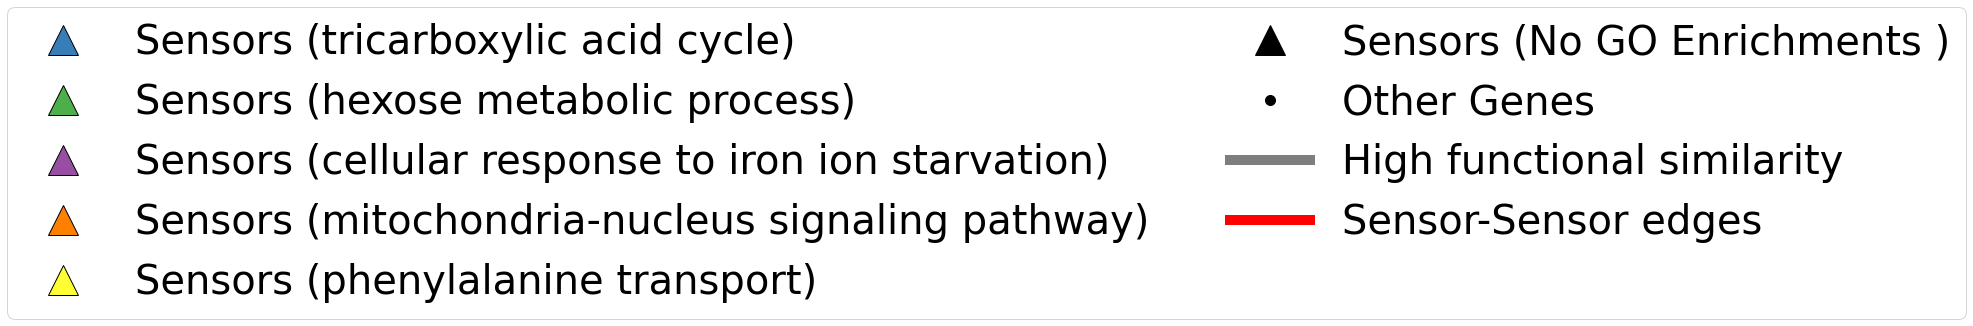

<Figure size 144x144 with 0 Axes>

In [32]:
fig = plt.figure()
figlegend = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
#lines = ax.plot(range(10), plt.randn(10), range(10), plt.randn(10))
ax.axis('off')
lgd = ax.legend(handles=legend_elements, fontsize=40, loc='center',ncol=2)
fig.show()

# Figure 4B

In [19]:
effector_pcc = pd.read_csv(snakemake.input.effector_pcc)
effector_colors = ["#A65628", "#F781BF", "#999999"]
effector_order = effector_pcc.groupby('go_group').eff.median().sort_values().index.tolist()

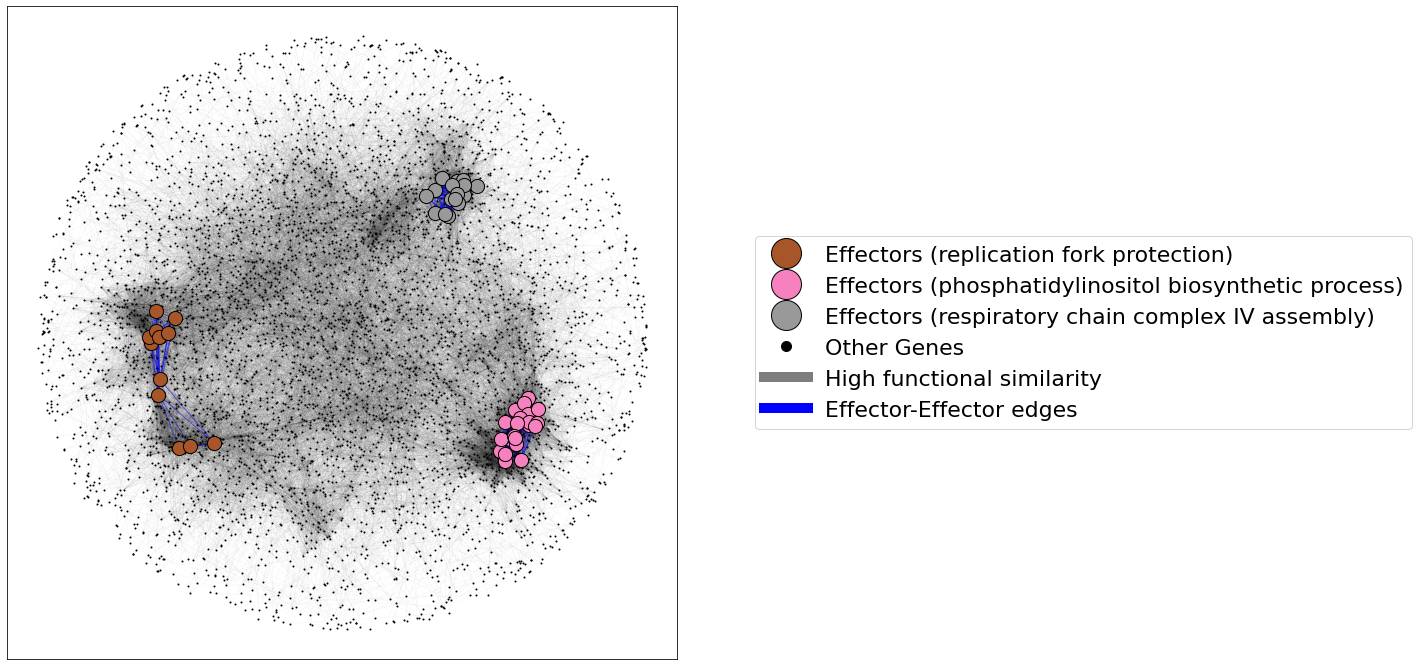

In [20]:
fig, ax = plt.subplots(figsize=(12,12))
#axs = ax.ravel()
legend_elements = [    ]

#for i in range(len(sensor_order)):
e_pcc.plot_network_spring(ax=ax,
                          node_size=1,
                          node_color='black',
 #                        node_size = [100 if i in sensors_pcc.orf_name.values or i in effector_pcc.orf_name.values else 1 for i in e_pcc.nodes],
                         #node_color = ['red' if i in sensors_pcc.orf_name.values else 'blue' if i in effector_pcc.orf_name.values else 'black' for i in e_pcc.nodes],
                         edge_color='black',savefig=False)
    #                         node_shape=['^' if i in sensors_pcc.orf_name.values else 'v' if i in effector_pcc.orf_name.values else 'o' for i in e_pcc.nodes])
    # nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=sensors_pcc.orf_name.values, node_size=200, pos=pos,
    #                           node_color='black',
    #                           node_shape='^',edgecolors='black',
    #                           linewidths=1)

for itr, i in enumerate(effector_order):
   # print(i, effector_colors[itr])
    #print(itr)
    
    orf_names_to_plot = effector_pcc.loc[effector_pcc.go_group==i, 'orf_name'].tolist()
    nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
                          node_color=effector_colors[itr],
                          node_shape='o',edgecolors='black',
                          linewidths=1)
    legend_elements.append(
        Line2D([0], [0], marker='o', color='black', label=f'Effectors ({i})',
                              markerfacecolor=effector_colors[itr], markersize=30, linestyle="None")
    )
ax.set_facecolor('white')
legend_elements.extend(
    [Line2D([0], [0], marker='o', color='black', label='Other Genes',
                              markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='o', color='black', label='Effectors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='^', color='black', label='Sensors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'High functional similarity',
                              markerfacecolor='black', markersize=0, linestyle="-", alpha=0.5,lw=10),
                   Line2D([0], [0], marker='o', color='blue', label= 'Effector-Effector edges',
                             markerfacecolor='#a6611a', markersize=0, linestyle="-",lw=10)
    ]
)
lgd = ax.legend(handles=legend_elements, fontsize=22,loc='center left', bbox_to_anchor=(1.1, 0.5))


nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
#plt.savefig('reports/figures/network_images_040221/tmp_nw_eff.png',bbox_inches='tight')

# Figure 5D/F

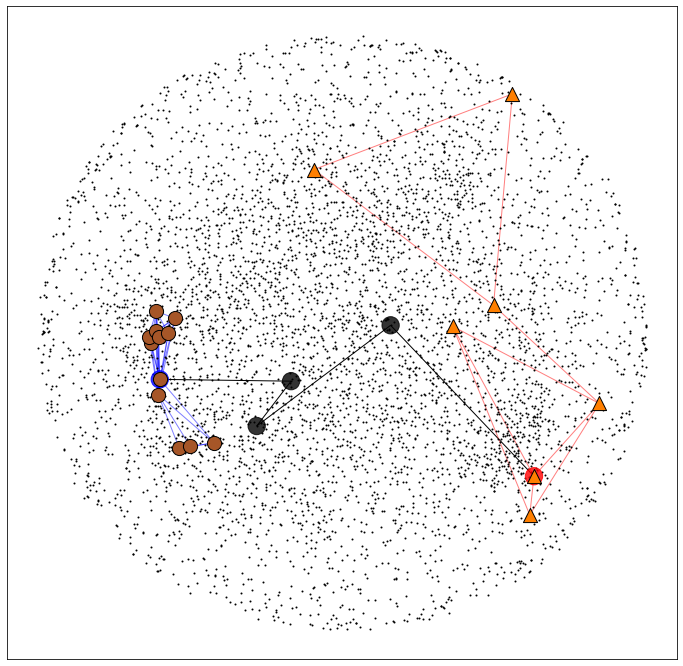

In [22]:
#define source and target effector/sensor clusters

eff_group = 'replication fork protection'
sens_group = 'mitochondria-nucleus signaling pathway'
#select source and target gene from respective clusters
source = 'ctf4'
target = 'rtg1'
#calculate source and tartget
l1 = e_pcc.get_prs_weighted_path(source,target)[1]
sub = nx.induced_subgraph(e_pcc.graph_gc, l1)

fig, ax = plt.subplots(figsize=(12,12))
legend_elements = [    ]
nx.draw_networkx_nodes(e_pcc.graph_gc, pos=pos, node_size=1, ax=ax, node_color='black')

nx.draw_networkx_nodes(sub,pos=pos,alpha=0.8,
                    #  node_size = [prs_mat_df.loc[source,:].to_dict()[i]*10000 for i in sub.nodes],
       node_color = ['red'  if i ==target or i == 'fum1' or i=='fbp1' else 'blue' if i==source  else 'black' for i in sub.nodes])

nx.draw_networkx_edges(sub,pos=pos)

for itr, i in enumerate(sensor_order):
    if i ==sens_group:
        orf_names_to_plot = sensors_pcc.loc[sensors_pcc.go_group==i, 'orf_name'].tolist()
        nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
                              node_color=sensor_colors[itr],
                              node_shape='^',edgecolors='black',
                              linewidths=1)
        nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, orf_names_to_plot), ax=ax , pos=pos, edge_color='red',alpha=0.5)

        legend_elements.append(
            Line2D([0], [0], marker='^', color='black', label=f'Sensors ({i})',
                                  markerfacecolor=sensor_colors[itr], markersize=12, linestyle="None")
        )

for itr, i in enumerate(effector_order):
    if i == eff_group:
        orf_names_to_plot = effector_pcc.loc[effector_pcc.go_group==i,'orf_name'].tolist()
        nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
                              node_color=effector_colors[itr],
                              node_shape='o',edgecolors='black',
                              linewidths=1)
        nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, orf_names_to_plot), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
        if i == 'mito':
            lbl = 'Respiratory complex assembly'
        elif i == 'golgi':
            lbl = "Golgi vesicle transport"
        else:
            lbl = 'Chromosome segragation'
        legend_elements.append(
                Line2D([0], [0], marker='o', color='black', label=f'Effectors ({lbl})',
                                      markerfacecolor=effector_colors[itr], markersize=12, linestyle="None")
            )
ax.set_facecolor('white')
# legend_elements.extend(
#     [Line2D([0], [0], marker='o', color='black', label='Genes',
#                               markerfacecolor='black', markersize=4, linestyle="None"),
# #                    Line2D([0], [0], marker='o', color='black', label='Effectors',
# #                               markerfacecolor='black', markersize=10, linestyle="None"),
# #                    Line2D([0], [0], marker='^', color='black', label='Sensors',
# #                               markerfacecolor='black', markersize=10, linestyle="None"),
#                        Line2D([0], [0], marker='o', color='black', label= 'High functional similarity',
#                               markerfacecolor='black', markersize=0, linestyle="-"),
#                    Line2D([0], [0], marker='o', color='red', label= 'Sensor-Sensor edges',
#                               markerfacecolor='#018571', markersize=0, linestyle="-"),
#                    Line2D([0], [0], marker='o', color='blue', label= 'Effector-Effector edges',
#                               markerfacecolor='#a6611a', markersize=0, linestyle="-")]
# )
#nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='red', alpha=0.5)
#lgd = ax.legend(handles=legend_elements, fontsize=22,loc='center left', bbox_to_anchor=(1.1, 0.5))
# nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=effector_pcc.orf_name.values, node_size=100, pos=pos,
#                       node_color='black',
#                       node_shape='o')
# nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=sensors_pcc.orf_name.values, node_size=200, pos=pos,
#                           node_color='black',
#                           node_shape='^',edgecolors='black',
#                           linewidths=1)
# nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
#plt.savefig('tmp_nw.png',bbox_inches='tight')

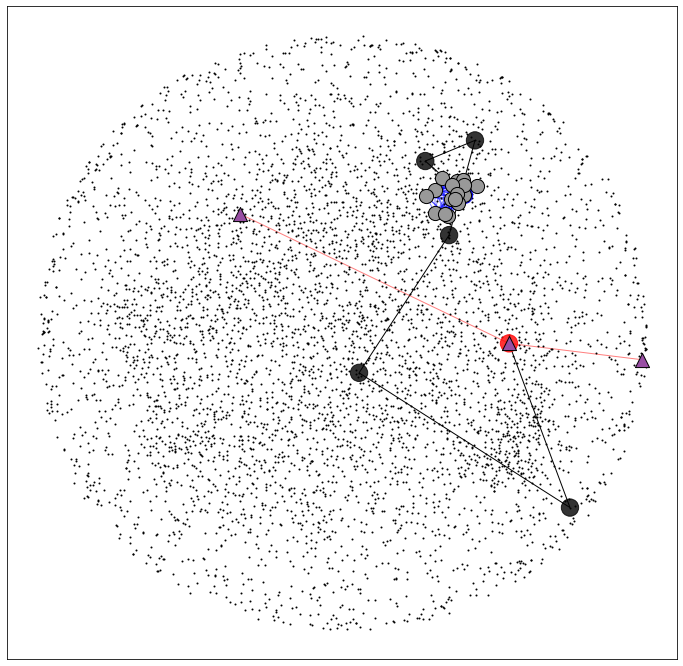

In [23]:
eff_group = 'respiratory chain complex IV assembly'
sens_group = 'cellular response to iron ion starvation'

source = 'aim10'
target = 'fet3'
l1 = e_pcc.get_prs_weighted_path(source,target)[1]
sub = nx.induced_subgraph(e_pcc.graph_gc, l1)

fig, ax = plt.subplots(figsize=(12,12))
legend_elements = [    ]
nx.draw_networkx_nodes(e_pcc.graph_gc, pos=pos, node_size=1, ax=ax, node_color='black')
nx.draw_networkx_nodes(sub,pos=pos,alpha=0.8,
                    #  node_size = [prs_mat_df.loc[source,:].to_dict()[i]*10000 for i in sub.nodes],
       node_color = ['red'  if i ==target or i == 'fum1' or i=='fbp1' else 'blue' if i==source  else 'black' for i in sub.nodes])

nx.draw_networkx_edges(sub,pos=pos)

for itr, i in enumerate(sensor_order):
    #print(i, effector_colors[itr])
    if i ==sens_group:
        orf_names_to_plot = sensors_pcc.loc[sensors_pcc.go_group==i, 'orf_name'].tolist()
        nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
                              node_color=sensor_colors[itr],
                              node_shape='^',edgecolors='black',
                              linewidths=1)
        nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, orf_names_to_plot), ax=ax , pos=pos, edge_color='red',alpha=0.5)

        legend_elements.append(
            Line2D([0], [0], marker='^', color='black', label=f'Sensors ({i})',
                                  markerfacecolor=sensor_colors[itr], markersize=12, linestyle="None")
        )

for itr, i in enumerate(effector_order):
    if i == eff_group:
        orf_names_to_plot = effector_pcc.loc[effector_pcc.go_group==i,'orf_name'].tolist()
        nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
                              node_color=effector_colors[itr],
                              node_shape='o',edgecolors='black',
                              linewidths=1)
        nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, orf_names_to_plot), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
        if i == 'mito':
            lbl = 'Respiratory complex assembly'
        elif i == 'golgi':
            lbl = "Golgi vesicle transport"
        else:
            lbl = 'Chromosome segragation'
        legend_elements.append(
                Line2D([0], [0], marker='o', color='black', label=f'Effectors ({lbl})',
                                      markerfacecolor=effector_colors[itr], markersize=12, linestyle="None")
            )
ax.set_facecolor('white')
# legend_elements.extend(
#     [Line2D([0], [0], marker='o', color='black', label='Genes',
#                               markerfacecolor='black', markersize=4, linestyle="None"),
#                        Line2D([0], [0], marker='o', color='black', label= 'High functional similarity',
#                               markerfacecolor='black', markersize=0, linestyle="-"),
#                    Line2D([0], [0], marker='o', color='red', label= 'Sensor-Sensor edges',
#                               markerfacecolor='#018571', markersize=0, linestyle="-"),
#                    Line2D([0], [0], marker='o', color='blue', label= 'Effector-Effector edges',
#                               markerfacecolor='#a6611a', markersize=0, linestyle="-")]
# )
#nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='red', alpha=0.5)
#lgd = ax.legend(handles=legend_elements, fontsize=22,loc='center left', bbox_to_anchor=(1.1, 0.5))
# nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=effector_pcc.orf_name.values, node_size=100, pos=pos,
#                       node_color='black',
#                       node_shape='o')
# nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=sensors_pcc.orf_name.values, node_size=200, pos=pos,
#                           node_color='black',
#                           node_shape='^',edgecolors='black',
#                           linewidths=1)
# nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
#plt.savefig('tmp_nw.png',bbox_inches='tight')